# CIFAR 10

## Getting the Data ready

In [0]:
# !pip install fastai==0.7.0
# import sys
# !{sys.executable} -m pip install torchtext==0.2.3

In [0]:
# !wget http://pjreddie.com/media/files/cifar.tgz -o cifar.tgz
# !tar xzf cifar.tgz

In [0]:
!ls cifar/train

In [0]:
PATH = 'cifar/'

TRN_PATH = f'{PATH}train/'
VAL_PATH = f'{PATH}test/'

In [18]:
'0_frog.png'.split('_')[1].split('.')[0]

'frog'

In [0]:
import os
import glob
import shutil

In [0]:
def prepare_data(path):
  folders = glob.glob(f'{path}*', recursive=True)
  for f in folders:
    folder = f.split('_')[1].split('.')[0]
    folder = f'{path}{folder}'
    os.makedirs(folder, exist_ok=True)
    shutil.move(f, folder)

## Getting Started

In [0]:
from fastai.conv_learner import *
PATH = "cifar/"

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [0]:
def get_data(sz, bs):
  tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
  return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [0]:
bs = 256


### Look at data

In [0]:
data = get_data(32, 4)

In [0]:
x, y = next(iter(data.trn_dl))

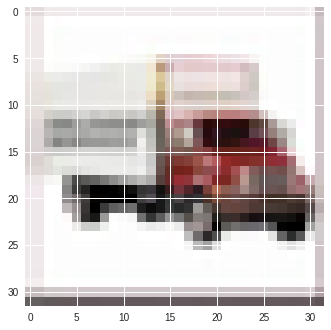

In [62]:
plt.imshow(data.trn_ds.denorm(x)[0]);

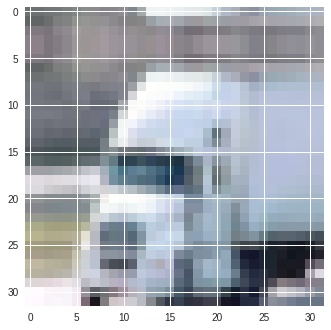

In [63]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully Connected Model

In [0]:
data = get_data(32, bs)

In [0]:
lr = 1e-2

In [0]:
class SimpleNet(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList([
        nn.Linear(layers[i], layers[i + 1]) for i in range((len(layers)) - 1)
    ])
    
  def forward(self, x):
    x = x.view(x.size(0), -1)
    for l in self.layers:
      l_x = l(x)
      x = F.relu(l_x)
    return F.log_softmax(l_x, dim=-1)

In [0]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40, 10]), data)

In [73]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [74]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [75]:
learn.lr_find()

 75%|███████▌  | 147/196 [00:18<00:05,  9.49it/s, loss=9.17]

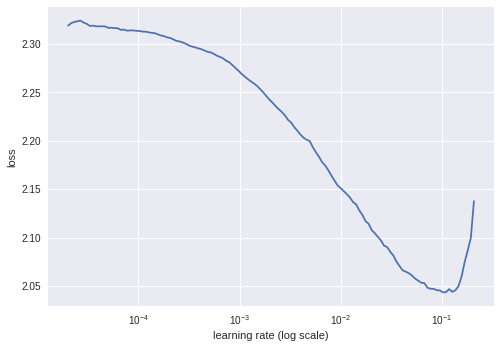

In [77]:
learn.sched.plot()

In [0]:
lr = 1e-2

In [80]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.805582   1.708719   0.4019    
    1      1.712267   1.605013   0.442     
CPU times: user 52.2 s, sys: 29.2 s, total: 1min 21s
Wall time: 54 s


[array([1.60501]), 0.442]

In [81]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.668665   1.560187   0.4543    
    1      1.623077   1.52623    0.4648    
CPU times: user 51.5 s, sys: 29.2 s, total: 1min 20s
Wall time: 53.4 s


[array([1.52623]), 0.4648]

## CNN

In [0]:
class ConvNet(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.layers = nn.ModuleList([
        nn.Conv2d(layers[i], layers[i+1], kernel_size=3, stride=2)
        for i in range(len(layers) - 1)
    ])
    self.pool = nn.AdaptiveMaxPool2d(1)
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    for l in self.layers:
      x = F.relu(l(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [84]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [87]:
learn.lr_find(end_lr=100)

 69%|██████▉   | 136/196 [00:17<00:05, 11.47it/s, loss=12.5]

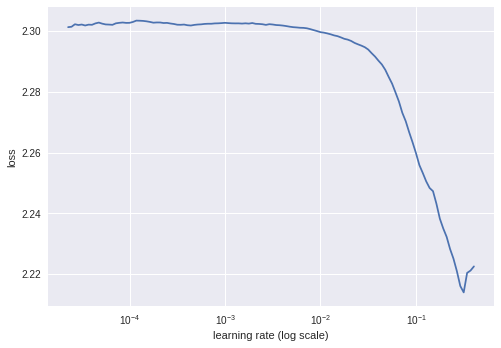

In [88]:
learn.sched.plot()

In [89]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.708505   1.62091    0.393     
    1      1.51834    1.444345   0.4717    
CPU times: user 54.6 s, sys: 31.2 s, total: 1min 25s
Wall time: 57.2 s


[array([1.44435]), 0.4717]

In [90]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.438254   1.360733   0.5011    
    1      1.357107   1.290921   0.5366    
    2      1.292869   1.240941   0.555     
    3      1.252286   1.189699   0.5716    
CPU times: user 1min 48s, sys: 1min, total: 2min 49s
Wall time: 1min 53s


[array([1.1897]), 0.5716]

## Refactored

In [0]:
class ConvLayer(nn.Module):
  def __init__(self, ni, nf):
    super().__init__()
    self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
    
  def forward(self, x):
    return F.relu(self.conv(x))

In [0]:
class ConvNet2(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i+1])
                                 for i in range(len(layers) - 1)
                                ])
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    for l in self.layers:
      x = l(x)
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [98]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [99]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.710691   1.574623   0.4245    
    1      1.51189    1.569124   0.4339    
CPU times: user 54.4 s, sys: 30.9 s, total: 1min 25s
Wall time: 57.1 s


[array([1.56912]), 0.4339]

In [100]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.491196   1.41403    0.4845    
    1      1.364404   1.300971   0.5302    
CPU times: user 55.7 s, sys: 31.4 s, total: 1min 27s
Wall time: 58.3 s


[array([1.30097]), 0.5302]

## BatchNorm

In [0]:
class BnLayer(nn.Module):
  def __init__(self, ni, nf, stride=2, kernel_size=3):
    super().__init__()
    self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                          bias=False, padding=1)
    self.a = nn.Parameter(torch.zeros(nf, 1, 1))
    self.m = nn.Parameter(torch.ones(nf, 1, 1))
    
  def forward(self, x):
    x = F.relu(self.conv(x))
    x_chan = x.transpose(0, 1).contiguous().view(x.size(1), -1)
    if self.training:
      self.means = x_chan.mean(1)[:, None, None]
      self.stds = x_chan.std(1)[:, None, None]
    return (x - self.means) / self.stds * self.m + self.a

In [0]:
class ConvBnNet(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
    self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                                 for i in range(len(layers) - 1)
                                ])
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    x = self.conv1(x)
    for l in self.layers:
      x = l(x)
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [120]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [121]:
%time learn.fit(3e-2, 2)


epoch      trn_loss   val_loss   accuracy   
    0      1.488324   1.383733   0.503     
    1      1.284924   1.234468   0.567     
CPU times: user 1min 1s, sys: 33.5 s, total: 1min 35s
Wall time: 1min 4s


[array([1.23447]), 0.567]

In [122]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.166452   1.087854   0.6195    
    1      1.051319   0.973843   0.6553    
    2      0.979629   0.896535   0.6808    
    3      0.923479   0.853638   0.7003    
CPU times: user 2min 2s, sys: 1min 5s, total: 3min 7s
Wall time: 2min 6s


[array([0.85364]), 0.7003]

## Deep BatchNorm

In [0]:
class ConvBnNet2(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
    self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                                 for i in range(len(layers) - 1)
                                ])
    self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i+1], 1)
                                 for i in range(len(layers) - 1)
                                ])
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    x = self.conv1(x)
    for l, l2 in zip(self.layers, self.layers2):
      x = l(x)
      x = l2(x)
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [129]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.495332   1.369385   0.509     
    1      1.270563   1.200253   0.5692    
CPU times: user 1min 8s, sys: 35.1 s, total: 1min 43s
Wall time: 1min 10s


[array([1.20025]), 0.5692]

In [131]:
%time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.067628   1.025661   0.6309    
    1      0.980023   0.920376   0.6725    
CPU times: user 1min 8s, sys: 34.9 s, total: 1min 43s
Wall time: 1min 10s


[array([0.92038]), 0.6725]

## RESNET

In [0]:
class ResnetLayer(BnLayer):
  def forward(self, x):
    return x + super().forward(x)

In [0]:
class Resnet(nn.Module):
  def __init__(self, layers, c):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
    self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                                 for i in range(len(layers) - 1)
                                ])
    self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
                                 for i in range(len(layers) - 1)
                                ])
    self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
                                 for i in range(len(layers) - 1)
                                ])
    self.out = nn.Linear(layers[-1], c)
    
  def forward(self, x):
    x = self.conv1(x)
    for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
      x = l3(l2(l(x)))
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [0]:
wd=1e-5

In [148]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy   
    0      1.593932   1.490919   0.4561    
    1      1.370725   1.308655   0.5295    
CPU times: user 1min 16s, sys: 39.5 s, total: 1min 56s
Wall time: 1min 23s


[array([1.30866]), 0.5295]

In [0]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy   
    0      1.18574    1.107915   0.6086    
    1      1.149864   1.05444    0.6203    
    2      1.019085   1.001963   0.6399    
    3      1.035067   0.995511   0.6503    
 36%|███▌      | 71/196 [00:14<00:15,  8.20it/s, loss=0.995]

In [0]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

## Resnet2

In [0]:
class Resnet2(nn.Module):
  def __init__(self, layers, c, p=0.5):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
    self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
                                 for i in range(len(layers) - 1)
                                ])
    self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
                                 for i in range(len(layers) - 1)
                                ])
    self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], 1)
                                 for i in range(len(layers) - 1)
                                ])
    self.out = nn.Linear(layers[-1], c)
    self.drop = nn.Dropout(p)
    
  def forward(self, x):
    x = self.conv1(x)
    for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
      x = l3(l2(l(x)))
    x = F.adaptive_max_pool2d(x, 1)
    x = x.view(x.size(0), -1)
    x = self.drop(x)
    return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [0]:
wd=1e-6

In [0]:
%time learn.fit(1e-2, 2, wds=wd)

In [0]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

In [0]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

In [0]:

learn.save('tmp3')

In [0]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [0]:
metrics.log_loss(y,preds), accuracy_np(preds,y)